In [4]:
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import ast
import models
import eventstox

%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

os.chdir('./goal_scoring_both_teams/')

In [5]:
df_1819 = pd.read_csv('df_1819.csv')
df_1920 = pd.read_csv('df_1920.csv')
df_2021 = pd.read_csv('df_2021.csv')

X_1819, y_1819 = eventstox.df_to_X_y(df_1819)
X_1920, y_1920 = eventstox.df_to_X_y(df_1920)
X_2021, y_2021 = eventstox.df_to_X_y(df_2021)

In [11]:
from imblearn.over_sampling import RandomOverSampler
import catboost


def model_train_eval_catboost(X_train, y_train, X_eval, y_eval, params):
    # Over sampling
    sampler = RandomOverSampler(random_state=20)
    X_train, y_train = sampler.fit_resample(X_train, y_train)

    categorical_features_indices = [i for i, col in enumerate(X_train.columns)
                                    if X_train[col].dtype == 'object']

    # Initialize CatBoostClassifier
    model = catboost.CatBoostClassifier(**params)

    # Train CatBoost
    model.fit(
        X_train,
        y_train,
        cat_features=categorical_features_indices,
        eval_set=(X_eval, y_eval)
    )

    # Making predictions
    # Probability for the positive class
    train_preds = model.predict_proba(X_train)[:, 1]
    # Probability for the positive class
    eval_preds = model.predict_proba(X_eval)[:, 1]

    return model, train_preds, eval_preds

In [6]:
X = pd.concat([X_1819, X_1920], axis=0).reset_index(drop=True)
y = np.concatenate([y_1819, y_1920], axis=0)

# drop unecessary columns
X = X.drop(columns=['location_x_10', 'location_y_10',  'team_10','shot_angle'])

In [13]:
from joblib import Parallel, delayed
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import optuna


def train_eval_fold(train_index, eval_index, X, y, params):
    X_train, y_train = X.iloc[train_index], y[train_index]
    X_eval, y_eval = X.iloc[eval_index], y[eval_index]

    model, train_preds, eval_preds = model_train_eval_catboost(
        X_train=X_train,
        y_train=y_train,
        X_eval=X_eval,
        y_eval=y_eval,
        params=params
    )

    roc_auc = roc_auc_score(y_eval, eval_preds)
    return roc_auc


def objective(trial):
    # Suggesting parameters
    params = {
        'loss_function': 'Logloss',
        'learning_rate': 0.1,
        'depth': trial.suggest_int('depth', 4, 10, 2),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10, 2),
        'random_strength': trial.suggest_int('random_strength', 1, 20, 5),
        'iterations': trial.suggest_int('iterations', 100, 800, 100),
        'verbose': False
    }

    kf = StratifiedKFold(5)

    # Parallelizing the cross-validation
    roc_auc_scores = Parallel(n_jobs=-1)(
        delayed(train_eval_fold)(train_index, eval_index, X, y, params)
        for train_index, eval_index in kf.split(X, y)
    )

    average_roc_auc = np.mean(roc_auc_scores)
    return average_roc_auc


# Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust the number of trials as needed

best_params = study.best_params
print("Best parameters:", best_params)

[I 2024-01-09 14:10:23,251] A new study created in memory with name: no-name-1d61d8b2-696c-4a0d-9f63-187264679c99
[I 2024-01-09 14:10:31,781] Trial 0 finished with value: 0.7144308102594461 and parameters: {'depth': 4, 'l2_leaf_reg': 9, 'random_strength': 1, 'iterations': 100}. Best is trial 0 with value: 0.7144308102594461.
[I 2024-01-09 14:11:50,496] Trial 1 finished with value: 0.655437489752597 and parameters: {'depth': 6, 'l2_leaf_reg': 7, 'random_strength': 6, 'iterations': 700}. Best is trial 0 with value: 0.7144308102594461.
[I 2024-01-09 14:11:58,444] Trial 2 finished with value: 0.7034550978744891 and parameters: {'depth': 4, 'l2_leaf_reg': 1, 'random_strength': 11, 'iterations': 100}. Best is trial 0 with value: 0.7144308102594461.
[I 2024-01-09 14:18:23,399] Trial 3 finished with value: 0.6593623902530329 and parameters: {'depth': 10, 'l2_leaf_reg': 5, 'random_strength': 6, 'iterations': 700}. Best is trial 0 with value: 0.7144308102594461.
[I 2024-01-09 14:19:04,818] Trial

Best parameters: {'depth': 4, 'l2_leaf_reg': 7, 'random_strength': 6, 'iterations': 100}


In [14]:
# retrain the model

params = {
    'loss_function': 'Logloss',
    'learning_rate': 0.1,
    'depth': best_params['depth'],
    'l2_leaf_reg': best_params['l2_leaf_reg'],
    'random_strength': best_params['random_strength'],
    'iterations': best_params['iterations'],
    'verbose': False
}

categorical_features_indices = [i for i, col in enumerate(X.columns)
                                if X[col].dtype == 'object']

sampler = RandomOverSampler(random_state=20)
X_resample, y_resample = sampler.fit_resample(X, y)

catboost_model = catboost.CatBoostClassifier(**params)
catboost_model.fit(X, y, cat_features=categorical_features_indices)

# joblib.dump(catboost_model, 'catboost.joblib')

In [65]:
import joblib
import models

lgb = joblib.load('lgb.joblib')
catboost_model = joblib.load('catboost.joblib')

X_test = models.process_X(X_2021).reset_index(drop=True)
y_test = y_2021[X_test.isna().sum(axis=1) == 0]
X_test = X_test.dropna().reset_index(drop=True)

X_test_lgb = X_test.copy()
X_test_catboost = X_test.drop(columns=['location_x_10', 'location_y_10',  'team_10','shot_angle'])

lgb_preds = lgb.predict(X_test_lgb)
catboost_preds = catboost_model.predict_proba(X_test_catboost)[:, 1]

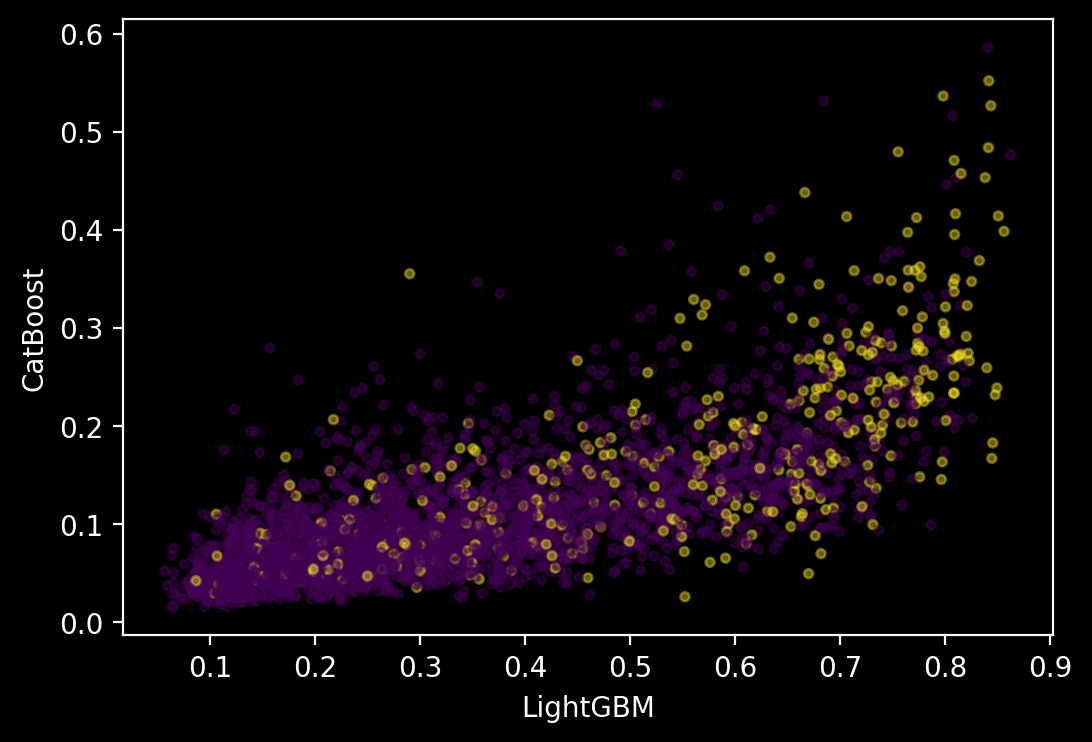

In [75]:
fig, ax = plt.subplots()

ax.scatter(
    lgb_preds,
    catboost_preds,
    s=10,
    c=y_test,
    alpha=0.4
)
ax.set_xlabel('LightGBM')
ax.set_ylabel('CatBoost')
fig.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler

X = pd.concat([X_1819, X_1920], axis=0).reset_index(drop=True)
y = np.concatenate([y_1819, y_1920], axis=0)

# drop unecessary columns
X = X.drop(columns=[col for col in X.columns if 'type' in col])
X = X.drop(columns=['location_x_10', 'location_y_10', 'shot_angle', 'team_10'])

# get binary features
X_binary = X[[col for col in X.columns if (
    ('team' in col) | ('outcome' in col))]]

# standard scaling on numerical features (locations)
X_numerical = X.drop(
    columns=X_binary.columns)

scaler = MinMaxScaler((0, 1))
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_numerical),
    columns=X_numerical.columns,
)

X_scaled = pd.concat([X_binary, X_scaled], axis=1)

In [8]:
def get_lstm_X(X_scaled):
    X_arr = np.zeros((X_scaled.shape[0], 10, 6))

    # List of features
    features = ["team", "outcome", "location_x",
                "location_y", "end_location_x", "end_location_y"]

    # Iterate over each feature and timestamp to fill the array
    for i, feature in enumerate(features):
        for timestamp in range(10):
            column_name = f"{feature}_{timestamp}"
            X_arr[:, timestamp, i] = X_scaled[column_name]

    return X_arr

In [9]:
import optuna
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from joblib import Parallel, delayed
import tensorflow as tf
import os


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


def objective(trial):
    # Suggested hyperparameters
    lstm_units = trial.suggest_categorical('lstm_units', [20, 50, 100])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-2, 1e-1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    # Modify the create_model function to accept hyperparameters
    def create_model(lstm_units, dropout_rate, learning_rate, optimizer):
        model = Sequential()
        model.add(LSTM(lstm_units, return_sequences=True, input_shape=(10, 6)))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(lstm_units))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))

        if optimizer == 'adam':
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

        model.compile(optimizer=opt, loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

    # Cross-validation
    kf = KFold(n_splits=5)
    auc_scores = []

    for train_index, val_index in kf.split(X_scaled):
        X_train, X_val = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]

        X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)
        X_train = get_lstm_X(X_train)
        X_val = get_lstm_X(X_val)

        model = create_model(lstm_units, dropout_rate,
                             learning_rate, optimizer)
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        eval_preds = model.predict(X_val).ravel()
        auc_score = roc_auc_score(y_true=y_val, y_score=eval_preds)
        auc_scores.append(auc_score)
    
    return np.mean(auc_scores)


# Run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Best hyperparameters
print(study.best_params)

2024-01-18 21:10:21.746434: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 21:10:21.958349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 21:10:21.958595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 21:10:21.996421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 21:10:22.095794: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 21:10:22.098616: I tensorflow/core/platform/cpu_feature_guard.cc:1

32/32 [==============================] - 1s 10ms/step


[I 2024-01-18 21:13:58,380] Trial 0 finished with value: 0.539519538366467 and parameters: {'lstm_units': 50, 'dropout_rate': 0.38648201454721853, 'learning_rate': 0.05312926733427578, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.539519538366467.


32/32 [==============================] - 2s 9ms/step


[I 2024-01-18 21:18:37,520] Trial 1 finished with value: 0.5580459313496717 and parameters: {'lstm_units': 50, 'dropout_rate': 0.3696428572001528, 'learning_rate': 0.04614377091203563, 'optimizer': 'adam'}. Best is trial 1 with value: 0.5580459313496717.


32/32 [==============================] - 2s 14ms/step


[I 2024-01-18 21:22:24,914] Trial 2 finished with value: 0.579355024170315 and parameters: {'lstm_units': 20, 'dropout_rate': 0.33809933449867957, 'learning_rate': 0.04719543310271078, 'optimizer': 'rmsprop'}. Best is trial 2 with value: 0.579355024170315.


32/32 [==============================] - 1s 6ms/step


[I 2024-01-18 21:27:01,536] Trial 3 finished with value: 0.6762618958376642 and parameters: {'lstm_units': 50, 'dropout_rate': 0.19912082877240614, 'learning_rate': 0.01903335526642985, 'optimizer': 'adam'}. Best is trial 3 with value: 0.6762618958376642.


32/32 [==============================] - 1s 9ms/step


[I 2024-01-18 21:30:32,383] Trial 4 finished with value: 0.6878379059798966 and parameters: {'lstm_units': 20, 'dropout_rate': 0.19686487828462487, 'learning_rate': 0.023180910902116516, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 9ms/step


[I 2024-01-18 21:37:14,053] Trial 5 finished with value: 0.5372909070830373 and parameters: {'lstm_units': 100, 'dropout_rate': 0.29711513448383275, 'learning_rate': 0.06188116020777766, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 2s 7ms/step


[I 2024-01-18 21:41:14,216] Trial 6 finished with value: 0.5179735666803015 and parameters: {'lstm_units': 20, 'dropout_rate': 0.4167901831190719, 'learning_rate': 0.08470691463342013, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 9ms/step


[I 2024-01-18 21:45:10,283] Trial 7 finished with value: 0.6721730476845995 and parameters: {'lstm_units': 20, 'dropout_rate': 0.11325211406259356, 'learning_rate': 0.015554097051392206, 'optimizer': 'adam'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 2s 9ms/step


[I 2024-01-18 21:49:12,862] Trial 8 finished with value: 0.6878074568907424 and parameters: {'lstm_units': 20, 'dropout_rate': 0.4781459090518727, 'learning_rate': 0.016283072633648105, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 9ms/step


[I 2024-01-18 21:55:33,489] Trial 9 finished with value: 0.6676598828624872 and parameters: {'lstm_units': 100, 'dropout_rate': 0.46478262932930736, 'learning_rate': 0.010071668105014817, 'optimizer': 'adam'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 6ms/step


[I 2024-01-18 21:58:33,260] Trial 10 finished with value: 0.6740478979766741 and parameters: {'lstm_units': 20, 'dropout_rate': 0.25349293172122284, 'learning_rate': 0.02939803629635151, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 5ms/step


[I 2024-01-18 22:01:22,440] Trial 11 finished with value: 0.678006435066569 and parameters: {'lstm_units': 20, 'dropout_rate': 0.4654904681679566, 'learning_rate': 0.026086941271452523, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 5ms/step


[I 2024-01-18 22:03:59,190] Trial 12 finished with value: 0.6768835027628624 and parameters: {'lstm_units': 20, 'dropout_rate': 0.4876206314116408, 'learning_rate': 0.019398421941415087, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 5ms/step


[I 2024-01-18 22:06:31,859] Trial 13 finished with value: 0.6739296622893243 and parameters: {'lstm_units': 20, 'dropout_rate': 0.21509103712341093, 'learning_rate': 0.013000047878145014, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 5ms/step


[I 2024-01-18 22:09:08,529] Trial 14 finished with value: 0.6695626543222261 and parameters: {'lstm_units': 20, 'dropout_rate': 0.31136816782879595, 'learning_rate': 0.0238752452294822, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 8ms/step


[I 2024-01-18 23:16:53,344] Trial 15 finished with value: 0.5211102544716901 and parameters: {'lstm_units': 100, 'dropout_rate': 0.4219955245536361, 'learning_rate': 0.03381720664448161, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 5ms/step


[I 2024-01-18 23:19:02,605] Trial 16 finished with value: 0.6731224066625712 and parameters: {'lstm_units': 20, 'dropout_rate': 0.16202270335769536, 'learning_rate': 0.01485029780248198, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 5ms/step


[I 2024-01-18 23:21:10,966] Trial 17 finished with value: 0.6719761237288118 and parameters: {'lstm_units': 20, 'dropout_rate': 0.27317711465118416, 'learning_rate': 0.03426148579993393, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 6ms/step


[I 2024-01-18 23:23:43,382] Trial 18 finished with value: 0.6743031437047109 and parameters: {'lstm_units': 50, 'dropout_rate': 0.34179835433246436, 'learning_rate': 0.018303911418249, 'optimizer': 'adam'}. Best is trial 4 with value: 0.6878379059798966.


32/32 [==============================] - 1s 7ms/step


[I 2024-01-19 12:24:43,696] Trial 19 finished with value: 0.6627850160677445 and parameters: {'lstm_units': 100, 'dropout_rate': 0.2469567249779505, 'learning_rate': 0.011119009034120584, 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.6878379059798966.


{'lstm_units': 20, 'dropout_rate': 0.19686487828462487, 'learning_rate': 0.023180910902116516, 'optimizer': 'rmsprop'}


In [9]:
import optuna
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from joblib import Parallel, delayed
import tensorflow as tf
import os


def create_model(lstm_units, dropout_rate, learning_rate, optimizer):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(10, 6)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


X_train, y_train = RandomOverSampler().fit_resample(X_scaled, y)
X_train = get_lstm_X(X_train)

lstm_model = create_model(
    lstm_units=20,
    dropout_rate=0.19686487828462487,
    learning_rate=0.023180910902116516,
    optimizer='rmsprop',
)

lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

In [10]:
import joblib

joblib.dump(lstm_model, 'lstm.joblib')

['lstm.joblib']